# Forecasting and nowcasting with Google Flu Trends

https://www.bitbybitbook.com/en/1st-ed/observing-behavior/strategies/forecasting/

- 阅读Jeremy Ginsberg et al. (2009) Detecting influenza epidemics using search engine query data Nature volume 457, pp:1012–1014 https://www.nature.com/articles/nature07634#Ack1 

- **Google Query Data** https://static-content.springer.com/esm/art%3A10.1038%2Fnature07634/MediaObjects/41586_2009_BFnature07634_MOESM271_ESM.xls Query fractions for the top 100 search queries, sorted by mean Z-transformed correlation with CDC-provided ILI percentages across the nine regions of the United States. (XLS 5264 kb)

- **CDC’s ILI Data**. We use the weighted version of CDC’s ILI activity level as the estimation target (available at gis.cdc.gov/grasp/fluview/fluportaldashboard.html). The weekly revisions of CDC’s ILI are available at the CDC website for all recorded seasons (from week 40 of a given year to week 20 of the subsequent year). Click **Download Data** to get the data.

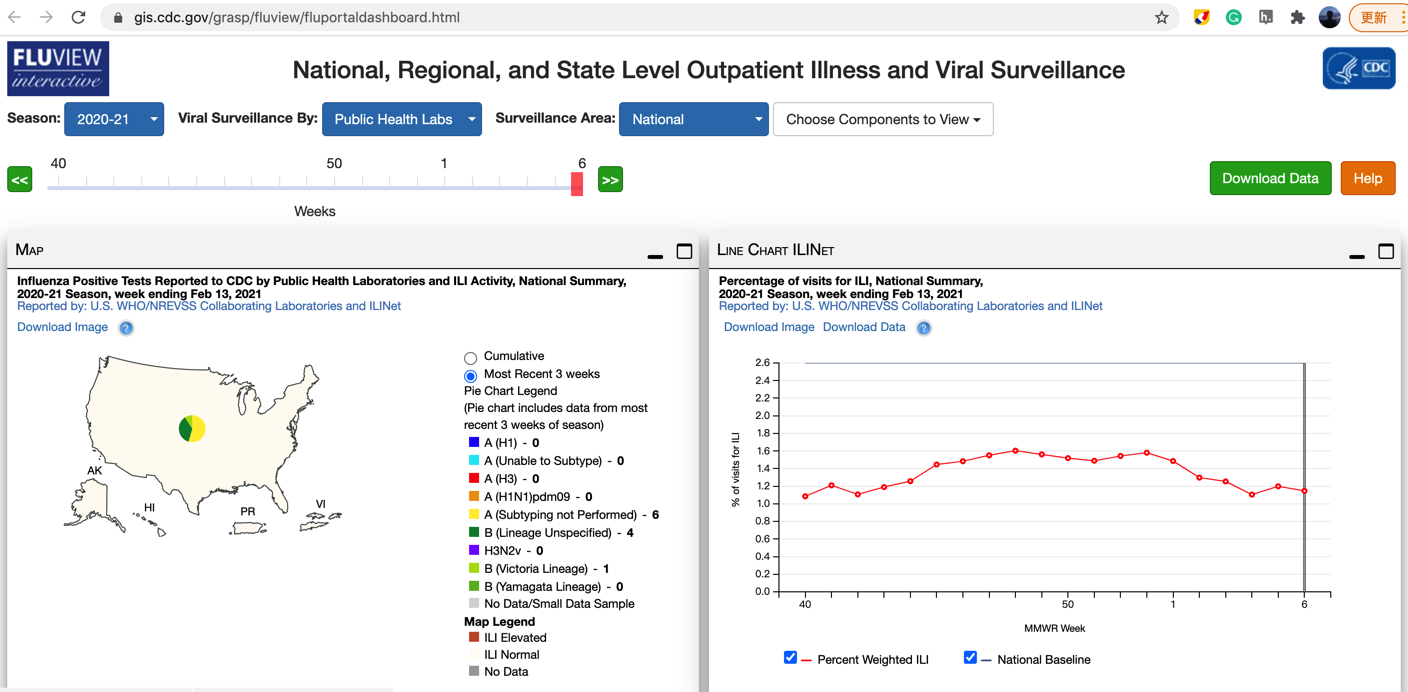

For example, ILI report revision at week 50 of season 2012–2013 is available at www.cdc.gov/flu/weekly/weeklyarchives2012-2013/data/senAllregt50.htm; ILI report revision at week 9 of season 2014–2015 is available at www.cdc.gov/flu/weekly/weeklyarchives2014-2015/data/senAllregt09.html.


In [1]:
ls

41586_2009_BFnature07634_MOESM271_ESM.xls
未命名.ipynb


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [42]:
df = pd.read_excel('41586_2009_BFnature07634_MOESM271_ESM.xls', sheet_name=1, header = 1)
df.head()

,Date,United States,New England Region,Mid-Atlantic Region,East North Central Region,West North Central Region,South Atlantic Region,East South Central Region,West South Central Region,Mountain Region,Pacific Region
0,2003-06-01,0.778,0.979,0.990,0.838,0.673,0.732,0.922,0.809,0.486,0.621
1,2003-06-08,0.850,0.932,0.806,0.879,0.839,0.852,0.479,0.800,1.383,1.008
2,2003-06-15,0.838,1.018,0.892,0.839,0.568,0.751,1.130,1.111,0.702,0.777
3,2003-06-22,0.828,0.615,1.149,0.676,0.730,0.867,1.149,0.498,0.936,0.734
4,2003-06-29,0.747,0.896,0.768,0.829,0.612,0.530,0.854,0.491,1.081,1.015


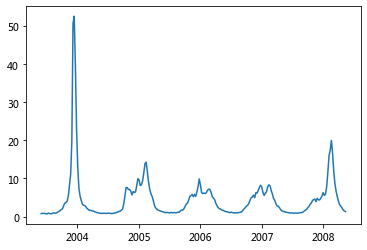

In [22]:
plt.plot(df['Date'], df['United States']);

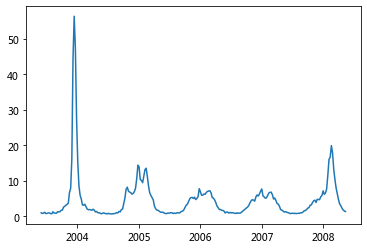

In [23]:
plt.plot(df['Date'], df['Mid-Atlantic Region']);

Figure 1: An evaluation of how many top-scoring queries to include in the ILI-related query fraction.

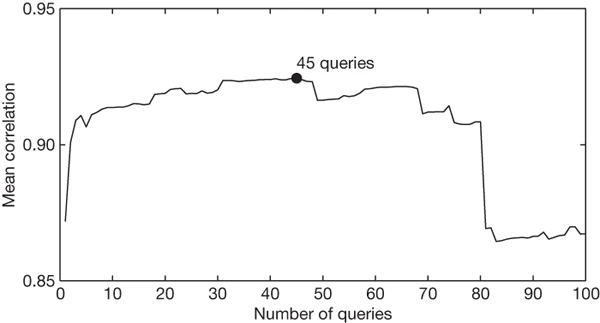

Maximal performance at estimating out-of-sample points during cross-validation was obtained by summing the top 45 search queries. A steep drop in model performance occurs after adding query 81, which is ‘oscar nominations’.

In [43]:
# Combine 45 queries
dict = {'date': df['Date'].tolist()}
for i in range(1, 46):
    df = pd.read_excel('41586_2009_BFnature07634_MOESM271_ESM.xls', sheet_name=i, header = 1)
    dict['query'+str(i)] = df['United States'].tolist()
dat = pd.DataFrame.from_dict(dict)
dat.head()

,date,query1,query2,query3,query4,query5,query6,query7,query8,query9,...,query36,query37,query38,query39,query40,query41,query42,query43,query44,query45
0,2003-06-01,0.778,5.297,6.096,0.893,1.036,1.357,0.124,0.366,0.675,...,0.483,0.131,0.633,0.173,0.241,0.848,0.138,0.190,2.027,2.133
1,2003-06-08,0.850,5.348,6.097,1.005,0.899,1.584,0.096,0.432,0.574,...,0.527,0.178,0.716,0.227,0.257,1.153,0.145,0.164,2.245,2.335
2,2003-06-15,0.838,4.961,5.772,0.868,0.811,1.515,0.084,0.392,0.563,...,0.509,0.156,0.760,0.213,0.234,1.123,0.138,0.213,2.338,2.311
3,2003-06-22,0.828,4.480,5.140,0.733,0.883,1.942,0.052,0.326,0.478,...,0.417,0.128,0.715,0.198,0.192,1.220,0.146,0.198,2.231,2.237
4,2003-06-29,0.747,3.910,4.409,0.637,0.726,1.580,0.049,0.352,0.364,...,0.429,0.080,0.671,0.150,0.153,1.114,0.138,0.165,2.005,2.085


In [51]:
# merge the ILI data
# cflu is CDC % ILI
dat2 = pd.read_csv('../GFT2.0/parable/ParableOfGFT(Replication).csv')
dat3 = dat2[['date', 'cflu']]
data = pd.merge(dat, dat3, how='right', on='date')
data.head()

,date,query1,query2,query3,query4,query5,query6,query7,query8,query9,...,query37,query38,query39,query40,query41,query42,query43,query44,query45,cflu
0,2003-09-28,1.853,6.679,7.824,1.072,2.399,1.623,0.162,0.606,0.731,...,0.224,0.741,0.324,0.496,1.267,0.294,0.204,2.097,2.905,0.884021
1,2003-10-05,1.976,6.310,8.259,1.194,2.733,1.589,0.167,0.607,0.662,...,0.210,0.852,0.295,0.442,1.329,0.322,0.225,2.233,2.713,1.027731
2,2003-10-12,2.834,6.911,9.009,1.228,3.304,1.581,0.221,0.664,0.783,...,0.259,0.890,0.306,0.413,1.392,0.353,0.201,2.305,2.874,1.282964
3,2003-10-19,3.501,7.492,9.611,1.291,3.846,1.619,0.326,0.698,0.841,...,0.260,0.900,0.352,0.450,1.357,0.383,0.255,2.279,2.965,1.326605
4,2003-10-26,3.721,7.121,9.352,1.309,3.876,1.640,0.288,0.674,0.762,...,0.260,0.950,0.293,0.393,1.367,0.319,0.271,2.317,2.986,1.773040


In [89]:
#data.to_csv('gft_ili_us.csv', index = False)

In [81]:
# filter data
data = data[data['query1'].notna()]
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date

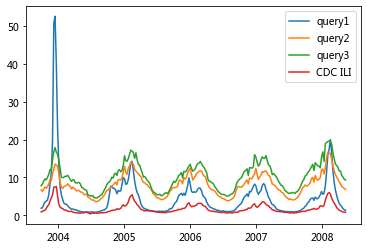

In [85]:
plt.plot(data['date'], data['query1'], label = 'query1')
plt.plot(data['date'], data['query2'], label = 'query2')
plt.plot(data['date'], data['query3'], label = 'query3')
plt.plot(data['date'], data['cflu'],  label = 'CDC ILI')
plt.legend()
plt.show()


Using this ILI-related query fraction as the explanatory variable, we fit a final linear model to weekly ILI percentages between 2003 and 2007 for all nine regions together, thus obtaining a single, region-independent coefficient. The model was able to obtain a good fit with CDC-reported ILI percentages, with a mean correlation of 0.90 (min = 0.80, max = 0.96, n = 9 regions; Fig. 2).

Figure 2: A comparison of model estimates for the mid-Atlantic region (black) against CDC-reported ILI percentages (red), including points over which the model was fit and validated.

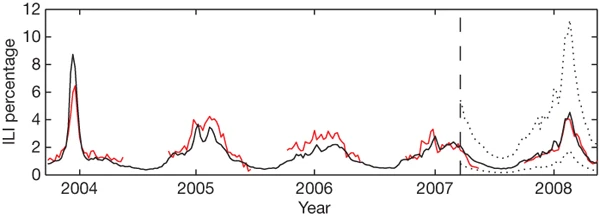

A correlation of 0.85 was obtained over 128 points from this region to which the model was fit, whereas a correlation of 0.96 was obtained over 42 validation points. Dotted lines indicate 95% prediction intervals. The region comprises New York, New Jersey and Pennsylvania.

Figure 3: ILI percentages estimated by our model (black) and provided by the CDC (red) in the **mid-Atlantic region**, showing data available at four points in the 2007-2008 influenza season.

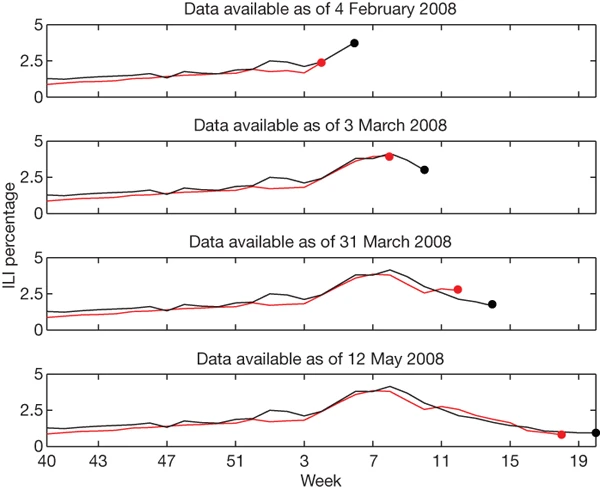

In [90]:
for i in range(1, 8):
    data["lag_{}".format(i)] = data['cflu'].shift(i)
print("done")
data=data.fillna(0)

done


In [131]:
y = data['cflu']
date = data['date']
X = data.drop(['cflu', 'date'], axis = 1)

In [96]:
len(y)

242

In [132]:
y

0      0.884021
1      1.027731
2      1.282964
3      1.326605
4      1.773040
         ...   
237    1.165197
238    1.020348
239    0.877607
240    0.825107
241    0.787315
Name: cflu, Length: 242, dtype: float64

In [133]:
X

,query1,query2,query3,query4,query5,query6,query7,query8,query9,query10,...,query43,query44,query45,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,1.853,6.679,7.824,1.072,2.399,1.623,0.162,0.606,0.731,0.145,...,0.204,2.097,2.905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.976,6.310,8.259,1.194,2.733,1.589,0.167,0.607,0.662,0.185,...,0.225,2.233,2.713,0.884021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.834,6.911,9.009,1.228,3.304,1.581,0.221,0.664,0.783,0.259,...,0.201,2.305,2.874,1.027731,0.884021,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.501,7.492,9.611,1.291,3.846,1.619,0.326,0.698,0.841,0.312,...,0.255,2.279,2.965,1.282964,1.027731,0.884021,0.000000,0.000000,0.000000,0.000000
4,3.721,7.121,9.352,1.309,3.876,1.640,0.288,0.674,0.762,0.321,...,0.271,2.317,2.986,1.326605,1.282964,1.027731,0.884021,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2.683,8.227,11.683,1.636,2.690,2.322,0.241,0.858,0.933,0.292,...,0.281,2.707,1.569,1.311296,1.652751,2.033656,2.692446,3.215218,3.832486,4.532340
238,2.290,7.648,10.502,1.435,2.359,2.239,0.165,0.769,0.850,0.225,...,0.254,2.568,1.510,1.165197,1.311296,1.652751,2.033656,2.692446,3.215218,3.832486
239,1.766,7.375,10.081,1.258,2.031,2.194,0.142,0.735,0.775,0.214,...,0.237,2.480,1.468,1.020348,1.165197,1.311296,1.652751,2.033656,2.692446,3.215218
240,1.446,7.132,9.531,1.097,1.930,2.190,0.114,0.654,0.657,0.188,...,0.269,2.436,1.378,0.877607,1.020348,1.165197,1.311296,1.652751,2.033656,2.692446


In [99]:
N = 50
X_train = X.iloc[:N,]
X_test = X.iloc[N:,]
y_train = y[:N]
y_test = y[N:]

# 利用弹性网络
from sklearn.model_selection import cross_val_score
cv_model = ElasticNetCV(l1_ratio=0.5, eps=1e-3, n_alphas=200, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=200, tol=0.006, cv=10, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

# 训练模型              
cv_model.fit(X_train, y_train)

# 计算最佳迭代次数、alpha和ratio
print('最佳 alpha: %.8f'%cv_model.alpha_)
print('最佳 l1_ratio: %.3f'%cv_model.l1_ratio_)
print('迭代次数 %d'%cv_model.n_iter_)

最佳 alpha: 0.06455398
最佳 l1_ratio: 0.500
迭代次数 63


In [102]:
# 输出结果
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.899526504124001
Test r2 score:  0.8509986476456004
Train RMSE: 0.4792
Test RMSE: 0.4345


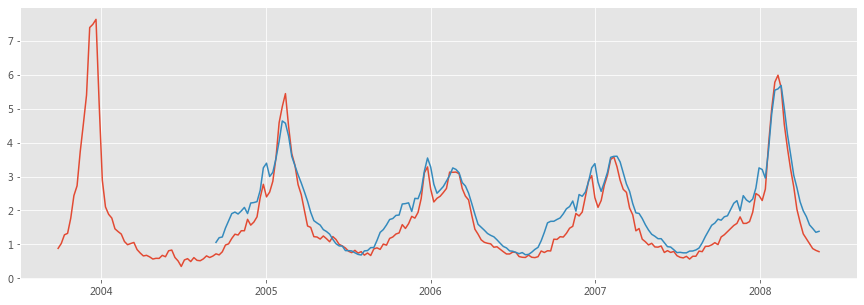

In [103]:
import datetime
plt.style.use('ggplot')

plt.rcParams.update({'figure.figsize': (15, 5)})

plt.plot(date, y)
plt.plot(date[N:], y_pred)

plt.show()

In fact, by using more careful methods, Lazer et al. (2014) and Yang, Santillana, and Kou (2015) were able to avoid these two problems.

- Yang, Shihao, Mauricio Santillana, and S. C. Kou. 2015. “Accurate Estimation of Influenza Epidemics Using Google Search Data via ARGO.” Proceedings of the National Academy of Sciences of the USA 112 (47):14473–8. https://doi.org/10.1073/pnas.1515373112.

- Lazer, David, Ryan Kennedy, Gary King, and Alessandro Vespignani. 2014. “The Parable of Google Flu: Traps in Big Data Analysis.” Science 343 (6176):1203–5. https://doi.org/10.1126/science.1248506.

# References

https://github.com/JEstebanMejiaV/The.Analytics.Edge/blob/352d59a27d2c376f268b1dbdf838e9ee77989d36/Unit%202%20-%20Linear%20Regression/Detecting%20Flu%20Epidemics%20via%20Search%20Engine%20Query%20Data.ipynb

In [86]:
dat = pd.read_csv('FluTrain.csv')
dat.head()

,Week,ILI,Queries
0,2004-01-04 - 2004-01-10,2.418331,0.237716
1,2004-01-11 - 2004-01-17,1.809056,0.220452
2,2004-01-18 - 2004-01-24,1.712024,0.225764
3,2004-01-25 - 2004-01-31,1.542495,0.237716
4,2004-02-01 - 2004-02-07,1.437868,0.224436


In [88]:
dat['Week']

0      2004-01-04 - 2004-01-10
1      2004-01-11 - 2004-01-17
2      2004-01-18 - 2004-01-24
3      2004-01-25 - 2004-01-31
4      2004-02-01 - 2004-02-07
                ...           
412    2011-11-27 - 2011-12-03
413    2011-12-04 - 2011-12-10
414    2011-12-11 - 2011-12-17
415    2011-12-18 - 2011-12-24
416    2011-12-25 - 2011-12-31
Name: Week, Length: 417, dtype: object

In [104]:
for i in range(1, 8):
    dat["lag_{}".format(i)] = dat['ILI'].shift(i)
print("done")
dat=dat.fillna(0)

done


In [128]:
y = dat['ILI']
week = dat['Week']
week = [i[:10] for i in week.tolist()]
week = pd.to_datetime(week)
X = dat.drop(['ILI', 'Week'], axis = 1)

In [130]:
y

0      2.418331
1      1.809056
2      1.712024
3      1.542495
4      1.437868
         ...   
412    1.465723
413    1.518106
414    1.663954
415    1.852736
416    2.124130
Name: ILI, Length: 417, dtype: float64

In [109]:
X

,Queries,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,0.237716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.220452,2.418331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.225764,1.809056,2.418331,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.237716,1.712024,1.809056,2.418331,0.000000,0.000000,0.000000,0.000000
4,0.224436,1.542495,1.712024,1.809056,2.418331,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
412,0.478088,1.655415,1.462212,1.440892,1.452843,1.305461,1.252586,1.236957
413,0.464807,1.465723,1.655415,1.462212,1.440892,1.452843,1.305461,1.252586
414,0.479416,1.518106,1.465723,1.655415,1.462212,1.440892,1.452843,1.305461
415,0.537849,1.663954,1.518106,1.465723,1.655415,1.462212,1.440892,1.452843


In [110]:
N = 100
X_train = X.iloc[:N,]
X_test = X.iloc[N:,]
y_train = y[:N]
y_test = y[N:]

# 利用弹性网络
from sklearn.model_selection import cross_val_score
cv_model = ElasticNetCV(l1_ratio=0.5, eps=1e-3, n_alphas=200, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=200, tol=0.006, cv=10, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

# 训练模型              
cv_model.fit(X_train, y_train)

# 计算最佳迭代次数、alpha和ratio
print('最佳 alpha: %.8f'%cv_model.alpha_)
print('最佳 l1_ratio: %.3f'%cv_model.l1_ratio_)
print('迭代次数 %d'%cv_model.n_iter_)

最佳 alpha: 0.00034012
最佳 l1_ratio: 0.500
迭代次数 15


In [111]:
# 输出结果
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.8704190473192481
Test r2 score:  0.9216895094890315
Train RMSE: 0.2868
Test RMSE: 0.3293


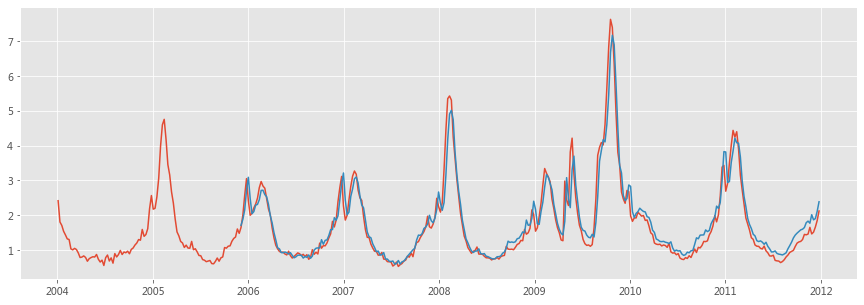

In [129]:
plt.plot(week, y)
plt.plot(week[N:], y_pred)
plt.show()